In [1]:
##################################################################
##################################################################
##################################################################
##################################################################
############################# PROJECT ############################
##################################################################
##################################################################
##################################################################
##################################################################
# - R. Andres Parra Sperberg, Alican G, Charlotte



##################################################################
################### IMPORT MODULES ###############################
##################################################################

# import pyrosetta
from pyrosetta import *
init("-mh:path:scores_BB_BB motif_dock/xh_16_ -mh:score:use_ss1 false -mh:score:use_ss2 false -mh:score:use_aa1 true -mh:score:use_aa2 true") # for docking

# setup pymol
from pyrosetta import PyMOLMover
pymol = PyMOLMover()


# import additional modules
from pyrosetta.teaching import *
import rosetta.protocols.rigid as rigid_moves
from rosetta.protocols.minimization_packing import *
from pyrosetta import PyMOLMover
import numpy as np
from rosetta.protocols import minimization_packing as pack_min
from rosetta.protocols.relax import FastRelax
import matplotlib.pyplot as plt

# import and clean pdb (superantigen + TCR + MHC)
from pyrosetta.toolbox import cleanATOM
cleanATOM("2ICW_MHC.pdb")
pose = pose_from_pdb("2ICW_MHC.clean.pdb")



core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: 2018.51.post.dev+654.v2019.01dev60566.dbc838b6ae6 dbc838b6ae620b1293476b1bd4366ffc2facc5b5 ssh://git@github.com/RosettaCommons/main 2019-01-03T10:31:13
core.init: command: PyRosetta -mh:path:scores_BB_BB motif_dock/xh_16_ -mh:score:use_ss1 false -mh:score:use_ss2 false -mh:score:use_aa1 true -mh:score:use_aa2 true -database /Volumes/coding/Users/coding/anaconda3/envs/coding/lib/python3.6/site-packages/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=1906184033 seed_offset=0 real_seed=1906184033
core.init.random: RandomGenerator:init: Normal mode, seed=1906184033 RG_type=mt19937


/Volumes/coding/Users/coding/anaconda3/envs/coding/lib/python3.6/site-packages/pyrosetta/teaching.py:13: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.core.scoring import *


core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 636 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.705556 seconds.
core.import_pose.import_pose: File '2ICW_MHC.clean.pdb' automatically determined to be of type PDB
core.conformation.Conformation: Found disulfide between residues 102 158
core.conformation.Conformation: current variant for 102 CYS
core.conformation.Conformation: current variant for 158 CYS
core.conformation.Conformation: current variant for 102 CYD
core.conformation.Conformation: current variant for 158 CYD
core.conformation.Conformation: Found disulfide between residues 191 255
core.conformation.Conformation: current variant for 191 CYS
core.conformation.Conformation: current variant for 255 CYS
core.conformation.Conformation: current variant for 191 CYD
core.conformation.Conformation: current variant for 255 CYD
core.conformation.Conformation: Found disulfide between residues 288 344
core.con

In [2]:
##################################################################
############### FUNCTIONS ########################################
##################################################################

# 1. Interface Packer
from pyrosetta.rosetta.protocols.interface import *
from pyrosetta.rosetta.core.select.residue_selector import *
from pyrosetta.rosetta.core.pack.task import *
from pyrosetta.rosetta.protocols.minimization_packing import *

def interface_packer(pose):
    """Create a packer to pack the interface

    Argument: pose whose interface needs to be packed

    return: a PackRotamersMover which repacks the interface,
    but doesn't change rotamers elsewhere
    """

    intf_resi_bool_vec = select_interface_residues(pose, "DEF_H", 8)

    intf_resi = ReturnResidueSubsetSelector(intf_resi_bool_vec)

    tf = TaskFactory()
    tf.push_back(operation.RestrictToRepacking()) # prevent design
    prevent_around_interface = operation.PreventRepackingRLT()
    # prevent repacking of all residues except interface residues
    # setting the 3rd argument to True flips the subset
    repack_only_intf_resi = operation.OperateOnResidueSubset(prevent_around_interface, intf_resi, True)
    tf.push_back(repack_only_intf_resi)

    packer = PackRotamersMover(fa_sfxn)
    packer.task_factory(tf)

    return packer

##################################################################
################### IMPORT POSE ##################################
##################################################################

# make full-atom starting pose
fa_starting = Pose()
fa_starting.assign(pose)
# make a full-atom working pose
fa_working = Pose()
fa_working.assign(pose)
# show starting
pymol.pymol_name("starting_pose")
pymol.apply(fa_starting)


### HACK ###
# replace fa_working with the relaxed structure
relaxed = pose_from_pdb("relaxed.pdb")
fa_working.assign(relaxed)

core.import_pose.import_pose: File 'relaxed.pdb' automatically determined to be of type PDB
core.conformation.Conformation: Found disulfide between residues 191 255
core.conformation.Conformation: current variant for 191 CYS
core.conformation.Conformation: current variant for 255 CYS
core.conformation.Conformation: current variant for 191 CYD
core.conformation.Conformation: current variant for 255 CYD
core.conformation.Conformation: Found disulfide between residues 102 158
core.conformation.Conformation: current variant for 102 CYS
core.conformation.Conformation: current variant for 158 CYS
core.conformation.Conformation: current variant for 102 CYD
core.conformation.Conformation: current variant for 158 CYD
core.conformation.Conformation: Found disulfide between residues 288 344
core.conformation.Conformation: current variant for 288 CYS
core.conformation.Conformation: current variant for 344 CYS
core.conformation.Conformation: current variant for 288 CYD
core.conformation.Conformatio

In [ ]:
##################################################################
########################## RELAX #################################
##################################################################

# Set up task Factory
tf_relax = TaskFactory()
tf_relax.push_back(operation.RestrictToRepacking())

# Set up packer for pose
packer_relax = pack_min.PackRotamersMover()
packer_relax.task_factory(tf_relax) # sets the task factory to the packer
packer_relax.apply(fa_working) # applies packer to pose

# Initializes fast relax class
fr = FastRelax()

# score function for fast relax
sfxn_relax = get_score_function()
fr.set_scorefxn(sfxn_relax)

# apply fast relax to pose
fr.apply(fa_working)

pymol.pymol_name("relaxed_pose")
pymol.apply(fa_starting)
pose.dump_pdb("2ICW_MHC_relaxed.pdb")



In [ ]:
thePose = Pose()
thePose.assign(fa_working)

pymol.pymol_name("relaxed_pose")
pymol.apply(thePose)
thePose.dump_pdb("theReal.pdb")

In [3]:
##################################################################
##################################################################
##################################################################
##################################################################
############################# DOCK ###############################
##################################################################
##################################################################
##################################################################
##################################################################

##################################################################
########################### IMPORT ###############################
##################################################################

# load a protein:
dock_pose = fa_working.clone()
native_pose = fa_starting.clone()


##################################################################
################### SWITCH TO CENTROID ###########################
##################################################################

# switch to centroid
switch = SwitchResidueTypeSetMover("centroid")
switch.apply(dock_pose)
switch.apply(native_pose)



##################################################################
################### CHANGE FOLD TREE #############################
##################################################################

# print pdb pose_tree
print(dock_pose.fold_tree())

# change fold tree to keep DEF fixed and move H
setup_foldtree(dock_pose, "DEF_H", Vector1([1])) # "DEF_H"
print(dock_pose.fold_tree())

# set jump information
jump_num = 1

core.chemical.GlobalResidueTypeSet: Finished initializing centroid residue type set.  Created 62 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.022361 seconds.
FOLD_TREE  EDGE 1 176 -1  EDGE 1 177 1  EDGE 177 361 -1  EDGE 1 362 2  EDGE 362 374 -1  EDGE 1 375 3  EDGE 375 587 -1 
FOLD_TREE  EDGE 1 25 -1  EDGE 25 176 -1  EDGE 25 435 1  EDGE 176 177 3  EDGE 435 375 -1  EDGE 435 587 -1  EDGE 177 361 -1  EDGE 361 362 2  EDGE 362 374 -1 


In [4]:
##################################################################
#################### CENTROID ENERGY FUNCTION ####################
##################################################################

# this is the table used for centroid mode docking
motif_dock_score = create_score_function("motif_dock_score")

# what is the score?
print(motif_dock_score(dock_pose)) # zero

basic.io.database: Database file opened: scoring/score_functions/InterchainPotential/interchain_env_log.txt
basic.io.database: Database file opened: scoring/score_functions/InterchainPotential/interchain_pair_log.txt
basic.io.database: Database file opened: scoring/score_functions/EnvPairPotential/env_log.txt
basic.io.database: Database file opened: scoring/score_functions/EnvPairPotential/cbeta_den.txt
basic.io.database: Database file opened: scoring/score_functions/EnvPairPotential/pair_log.txt
basic.io.database: Database file opened: scoring/score_functions/EnvPairPotential/cenpack_log.txt
core.scoring.motif: init MotifHashManager
core.scoring.motif: reading xform_score_data_BB_BB
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_AA.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_AC.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_AD.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_doc

core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FE.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FF.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FG.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FH.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FI.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FK.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FL.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FM.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FN.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FP.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FQ.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_FR.xh.bin.gz
core.scoring.mot

core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_KS.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_KT.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_KV.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_KW.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_KY.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_LA.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_LC.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_LD.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_LE.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_LF.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_LG.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_LH.xh.bin.gz
core.scoring.mot

core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QI.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QK.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QL.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QM.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QN.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QP.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QQ.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QR.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QS.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QT.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QV.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_QW.xh.bin.gz
core.scoring.mot

core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_VY.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WA.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WC.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WD.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WE.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WF.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WG.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WH.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WI.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WK.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WL.xh.bin.gz
core.scoring.motif: XformScore::read_binary(fname): motif_dock/xh_16_WM.xh.bin.gz
core.scoring.mot

In [5]:


##################################################################
############### BROAD LOCAL CENTROID MODE ########################
##################################################################

trans_mag = 3
rot_mag = 8
import rosetta.protocols.rigid as rigid_moves
rigid_body_mover = rigid_moves.RigidBodyPerturbMover(1, rot_mag, trans_mag)
rigid_body_mover.apply(dock_pose)

kT = 0.8
mc = MonteCarlo(dock_pose, motif_dock_score, kT)

# store the scores and Lrmsd
scores = np.array([])
Lrmsd = np.array([])

# current magnitudes
trans_mag = 3
rot_mag = 8
rigid_body_mover.trans_magnitude(trans_mag)
rigid_body_mover.rot_magnitude(rot_mag)

# add mover to the trial mover
trial_mover = TrialMover(rigid_body_mover, mc)
# trial_mover.apply(ras)

# loop through the monte carlo object
for i in range(10):
    for j in range(50):

        # apply the mover and update mc object
        trial_mover.apply(dock_pose)
        #pymol.apply(working_pose)

        # store scores and Lrmsd
        scores = np.append(scores, motif_dock_score(dock_pose))
        Lrmsd = np.append(Lrmsd, calc_Lrmsd(dock_pose, native_pose, Vector1([1])))

    # get the acceptance rate
    acc = trial_mover.acceptance_rate()
    print(acc)


    # change the magnitude dynamically
    if acc < 0.5:
        trans_mag = trans_mag*0.9
        rot_mag = rot_mag*0.9
        rigid_body_mover.trans_magnitude(trans_mag)
        rigid_body_mover.rot_magnitude(rot_mag)

        # now, update the trial mover with the new rigid body mover
        trial_mover = TrialMover(rigid_body_mover, mc)

    elif acc > 0.5:
        trans_mag = trans_mag*1.1
        rot_mag = rot_mag*1.1
        rigid_body_mover.trans_magnitude(trans_mag)
        rigid_body_mover.rot_magnitude(rot_mag)

        # now, update the trial mover with the new rigid body mover
        trial_mover = TrialMover(rigid_body_mover, mc)

mc.show_scores()
mc.recover_low(dock_pose)




protocols.TrialMover: Acceptance rate: 0.1
0.1
protocols.TrialMover: Acceptance rate: 0.02
0.02
protocols.TrialMover: Acceptance rate: 0.02
0.02
protocols.TrialMover: Acceptance rate: 0
0.0
protocols.TrialMover: Acceptance rate: 0
0.0
protocols.TrialMover: Acceptance rate: 0
0.0
protocols.TrialMover: Acceptance rate: 0
0.0
protocols.TrialMover: Acceptance rate: 0.02
0.02
protocols.TrialMover: Acceptance rate: 0
0.0
protocols.TrialMover: Acceptance rate: 0.02
0.02
protocols.moves.MonteCarlo: MonteCarlo:: last_accepted_score,lowest_score: -582.781 -582.781


[-543.07856014 -543.07856014 -543.07856014 -543.07856014 -543.07856014
 -543.07856014 -543.07856014 -543.07856014 -547.75803042 -547.75803042
 -547.75803042 -547.75803042 -547.75803042 -547.75803042 -547.75803042
 -554.29021142 -554.29021142 -554.29021142 -554.29021142 -554.29021142
 -554.29021142 -554.29021142 -554.29021142 -554.29021142 -564.62888099
 -572.85124889 -572.85124889 -572.85124889 -572.85124889 -572.85124889
 -572.85124889 -572.85124889 -572.85124889 -572.85124889 -572.85124889
 -572.85124889 -572.85124889 -572.85124889 -572.85124889 -572.85124889
 -572.85124889 -572.85124889 -572.85124889 -572.85124889 -572.85124889
 -572.85124889 -572.85124889 -572.85124889 -572.85124889 -572.85124889
 -572.85124889 -572.85124889 -572.85124889 -572.85124889 -572.85124889
 -572.85124889 -572.85124889 -572.85124889 -572.85124889 -572.85124889
 -572.85124889 -572.85124889 -572.85124889 -572.85124889 -572.85124889
 -572.85124889 -572.85124889 -572.85124889 -572.85124889 -572.85124889
 -572.

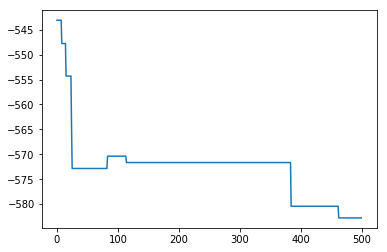

In [9]:
# make plot of scores vs iteration
print(scores)
plt.plot(scores) # first plot, scores vs iteration... point = we take lowest energy structure.


plt.savefig('centroid_scores_unrelaxed.png')




In [8]:
# store structure
pymol.pymol_name("centroid_dock")
pymol.apply(dock_pose)
dock_pose.dump_pdb("centroid_dock.pdb")

True

In [10]:

##################################################################
##################### SWITCH BACK TO FULL-ATOM ###################
##################################################################

switch_back = SwitchResidueTypeSetMover("fa_standard")
switch_back.apply(dock_pose)
#pymol.pymol_name("fa_pose")
#pymol.apply(working_pose)


##################################################################
############### FULL-ATOM ENERGY FUNCTION ########################
##################################################################

fa_sfxn = create_score_function("ref2015")



core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
basic.io.database: Database file opened: scoring/score_functions/rama/fd/all.ramaProb
basic.io.database: Database file opened: scor

In [11]:


##################################################################
############### FULL-ATOM REFINEMENT #############################
##################################################################

# current magnitudes
trans_mag = 0.1
rot_mag = 5
rigid_body_mover.trans_magnitude(trans_mag)
rigid_body_mover.rot_magnitude(rot_mag)

# full-atom montecarlo object
kT = 0.8
mc_fa = MonteCarlo(dock_pose, fa_sfxn, kT)

# trial mover
trial_mover = TrialMover(rigid_body_mover, mc_fa)

# store the scores and Lrmsd
scores = np.array([])
Lrmsd = np.array([])

# current magnitudes
trans_mag = 0.1
rot_mag = 5
rigid_body_mover.trans_magnitude(trans_mag)
rigid_body_mover.rot_magnitude(rot_mag)

# add mover to the trial mover
trial_mover = TrialMover(rigid_body_mover, mc_fa)
# trial_mover.apply(ras)

# loop through the monte carlo object
for i in range(5):
    for j in range(10):

        # apply the mover and update mc object
        trial_mover.apply(dock_pose)
        #pymol.apply(working_pose)

        # store scores and Lrmsd
        scores = np.append(scores, motif_dock_score(dock_pose))
        Lrmsd = np.append(Lrmsd, calc_Lrmsd(dock_pose, native_pose, Vector1([1])))

    # get the acceptance rate
    acc = trial_mover.acceptance_rate()
    print(acc)

    # change the magnitude dynamically
    if acc < 0.5:
        trans_mag = trans_mag*0.9
        rot_mag = rot_mag*0.9
        rigid_body_mover.trans_magnitude(trans_mag)
        rigid_body_mover.rot_magnitude(rot_mag)

        # now, update the trial mover with the new rigid body mover
        trial_mover = TrialMover(rigid_body_mover, mc_fa)

    elif acc > 0.5:
        trans_mag = trans_mag*1.1
        rot_mag = rot_mag*1.1
        rigid_body_mover.trans_magnitude(trans_mag)
        rigid_body_mover.rot_magnitude(rot_mag)

        # now, update the trial mover with the new rigid body mover
        trial_mover = TrialMover(rigid_body_mover, mc_fa)

    # recover lowest observed pose
    mc_fa.recover_low(dock_pose)

    # pack the rotamers at the interface
    interface_packer(dock_pose)

mc_fa.show_scores()
mc_fa.recover_low(dock_pose)
#pymol.apply(working_pose)

basic.io.database: Database file opened: scoring/score_functions/elec_cp_reps.dat
core.scoring.elec.util: Read 40 countpair representative atoms
core.pack.dunbrack.RotamerLibrary: shapovalov_lib_fixes_enable option is true.
core.pack.dunbrack.RotamerLibrary: shapovalov_lib::shap_dun10_smooth_level of 1( aka lowest_smooth ) got activated.
core.pack.dunbrack.RotamerLibrary: Binary rotamer library selected: /Volumes/coding/Users/coding/anaconda3/envs/coding/lib/python3.6/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin
core.pack.dunbrack.RotamerLibrary: Using Dunbrack library binary file '/Volumes/coding/Users/coding/anaconda3/envs/coding/lib/python3.6/site-packages/pyrosetta/database/rotamer/shapovalov/StpDwn_0-0-0/Dunbrack10.lib.bin'.
core.pack.dunbrack.RotamerLibrary: Dunbrack 2010 library took 0.221259 seconds to load from binary
protocols.TrialMover: Acceptance rate: 0.3
0.3
protocols.TrialMover: Acceptance rate: 0.3
0.3
protocols.TrialMover: Accept

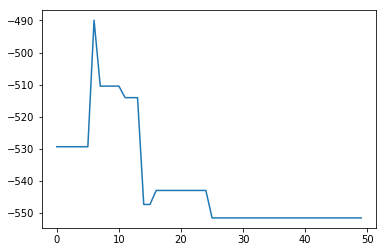

In [12]:
plt.plot(scores) # second plot, scores vs iteration... point = we take lowest energy structure for full-atom...
plt.savefig('fa_scores_relaxed.png')



In [13]:


pymol.pymol_name("fa_dock")
pymol.apply(dock_pose)
dock_pose.dump_pdb("fa_dock.pdb")



True

In [17]:



##################################################################
############### MINIMIZE #########################################
##################################################################
# alternatively: quick relax...

# Create a MinMover Object to minimize pose
from rosetta.protocols.minimization_packing import *
min_mover = MinMover()
mm_dock = MoveMap()
mm_dock.set_bb(True)
min_mover.movemap(mm_dock)
min_mover.score_function(fa_sfxn)

min_mover.apply(dock_pose)


# find score of best protein
print('best energy: ')
print(fa_sfxn(dock_pose))

##################################################################
##################################################################
##################################################################
##################################################################
############################# DESIGN #############################
##################################################################
##################################################################
##################################################################
##################################################################

##################################################################
########################### IMPORT ###############################
##################################################################

# load a protein:
design_pose = dock_pose.clone()

##################################################################
################### RESIDUE SELECTOR #############################
##################################################################

#find the pose numbering from pdb numbering
start_residue = design_pose.pdb_info().pdb2pose('D', 55)
end_residue = design_pose.pdb_info().pdb2pose('D', 72)

#first define the main helix of the antigen in contact with the protein
antigen_helix_selector = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector()
antigen_helix_selector.set_index("{}-{}".format(start_residue, end_residue))
antigen_helix_residue_vector = antigen_helix_selector.apply(design_pose)

#find the neighbors
antigen_helix_neighbor_selector = pyrosetta.rosetta.core.select.residue_selector.NeighborhoodResidueSelector(antigen_helix_residue_vector, 8, True)
antigen_helix_neighbors = antigen_helix_neighbor_selector.apply(design_pose)
not_antigen_helix_neighbors = pyrosetta.rosetta.core.select.residue_selector.NotResidueSelector(antigen_helix_neighbor_selector)


#define the chain H residues belonging to the protein
H_selector = pyrosetta.rosetta.core.select.residue_selector.ChainSelector('H')
DF_selector = pyrosetta.rosetta.core.select.residue_selector.ChainSelector('D,E,F')

#combine the chain selectors with the region selectors
combine_H_selectors = pyrosetta.rosetta.core.select.residue_selector.AND_combine(antigen_helix_neighbor_selector, H_selector)
not_combine_H_selectors = pyrosetta.rosetta.core.select.residue_selector.NotResidueSelector(combine_H_selectors)
H_residues_to_design = combine_H_selectors.apply(design_pose)

combine_DF_selectors = pyrosetta.rosetta.core.select.residue_selector.AND_combine(antigen_helix_neighbor_selector, DF_selector)
not_combine_DF_selectors = pyrosetta.rosetta.core.select.residue_selector.NotResidueSelector(combine_DF_selectors)
DF_residues_to_repack = combine_DF_selectors.apply(design_pose)


##################################################################
########################## PACKER ################################
##################################################################

# setup the packer-task
tf_design = pyrosetta.rosetta.core.pack.task.TaskFactory()

# These are pretty standard
tf_design.push_back(pyrosetta.rosetta.core.pack.task.operation.InitializeFromCommandline())
tf_design.push_back(pyrosetta.rosetta.core.pack.task.operation.IncludeCurrent())
tf_design.push_back(pyrosetta.rosetta.core.pack.task.operation.NoRepackDisulfides())


# Disable repacking/design on non-interface
tf_design.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(
    pyrosetta.rosetta.core.pack.task.operation.PreventRepackingRLT(), not_antigen_helix_neighbors))

# Disable design (just repack) on MHC
tf_design.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(
    pyrosetta.rosetta.core.pack.task.operation.RestrictToRepackingRLT(), DF_residues_to_repack))

# Convert the task factory into a PackerTask
packer_task_design = tf_design.create_task_and_apply_taskoperations(design_pose)

# View the PackerTask
print(packer_task_design)


##################################################################
########################## MINIMIZER #############################
##################################################################

# setup the minimizer
mm_design = pyrosetta.rosetta.core.kinematics.MoveMap()
mm_design.set_bb(True)
mm_design.set_chi(True)
mm_design.set_jump(True) # psuedo docking...


##################################################################
######################## FAST DESIGN #############################
##################################################################

# setup fast design
scorefxn_design = pyrosetta.create_score_function("ref2015_cart.wts")
fast_design = pyrosetta.rosetta.protocols.denovo_design.movers.FastDesign(scorefxn_in=scorefxn_design, standard_repeats=1)
fast_design.cartesian(True)
fast_design.set_task_factory(tf_design)
fast_design.set_movemap(mm_design)
#fast_design.set_relaxscript(1) # lower it to 2....
#fast_design.minimize_bond_angles(True)
#fast_design.minimize_bond_lengths(True)

# apply fast design
fast_design.apply(design_pose)

# clone output
design_output = design_pose.clone()


# find score of best protein
print('best energy: ')
print(fa_sfxn(design_output))

pymol.pymol_name("design_output")
pymol.apply(design_pose)
design_pose.dump_pdb("design_output.pdb")


best energy: 
513895.6779187172
core.pack.task: Packer task: initialize from command line()
#Packer_Task

resid	pack?	design?	allowed_aas
1	FALSE	FALSE	
2	FALSE	FALSE	
3	FALSE	FALSE	
4	FALSE	FALSE	
5	FALSE	FALSE	
6	FALSE	FALSE	
7	FALSE	FALSE	
8	FALSE	FALSE	
9	FALSE	FALSE	
10	FALSE	FALSE	
11	FALSE	FALSE	
12	FALSE	FALSE	
13	FALSE	FALSE	
14	FALSE	FALSE	
15	FALSE	FALSE	
16	FALSE	FALSE	
17	FALSE	FALSE	
18	FALSE	FALSE	
19	FALSE	FALSE	
20	FALSE	FALSE	
21	FALSE	FALSE	
22	FALSE	FALSE	
23	FALSE	FALSE	
24	FALSE	FALSE	
25	FALSE	FALSE	
26	FALSE	FALSE	
27	FALSE	FALSE	
28	FALSE	FALSE	
29	FALSE	FALSE	
30	FALSE	FALSE	
31	FALSE	FALSE	
32	FALSE	FALSE	
33	FALSE	FALSE	
34	FALSE	FALSE	
35	FALSE	FALSE	
36	FALSE	FALSE	
37	TRUE	FALSE	THR
38	FALSE	FALSE	
39	FALSE	FALSE	
40	FALSE	FALSE	
41	FALSE	FALSE	
42	FALSE	FALSE	
43	FALSE	FALSE	
44	FALSE	FALSE	
45	FALSE	FALSE	
46	FALSE	FALSE	
47	FALSE	FALSE	
48	FALSE	FALSE	
49	TRUE	FALSE	SER
50	TRUE	FALSE	PHE
51	TRUE	FALSE	GLU
52	TRUE	FALSE	ALA
53	TRUE	FALSE	GLN
54	TRUE	FAL

protocols.denovo_design.movers.FastDesign: #Packer_Task
protocols.denovo_design.movers.FastDesign: 
protocols.denovo_design.movers.FastDesign: resid	pack?	design?	allowed_aas
protocols.denovo_design.movers.FastDesign: 1	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 2	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 3	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 4	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 5	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 6	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 7	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 8	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 9	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 10	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 11	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 12	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 13	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 14	FALSE	FALSE
protocols.denovo_desig

protocols.denovo_design.movers.FastDesign: 121	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 122	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 123	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 124	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 125	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 126	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 127	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 128	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 129	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 130	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 131	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 132	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 133	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 134	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 135	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 136	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 137	FALSE	FAL

protocols.denovo_design.movers.FastDesign: 244	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 245	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 246	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 247	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 248	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 249	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 250	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 251	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 252	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 253	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 254	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 255	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 256	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 257	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 258	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 259	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 260	FALSE	FAL

protocols.denovo_design.movers.FastDesign: 367	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 368	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 369	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 370	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 371	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 372	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 373	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 374	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 375	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 376	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 377	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 378	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 379	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 380	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 381	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 382	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 383	FALSE	FAL

protocols.denovo_design.movers.FastDesign: 490	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 491	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 492	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 493	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 494	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 495	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 496	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 497	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 498	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 499	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 500	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 501	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 502	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 503	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 504	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 505	FALSE	FALSE
protocols.denovo_design.movers.FastDesign: 506	FALSE	FAL

core.pose.util: [ WARNING ] Unable to find atom_tree atom for this Rosetta branch connection angle: residue 191 BRANCH 1
core.pose.util: [ WARNING ] Unable to find atom_tree atom for this Rosetta branch connection angle: residue 255 BRANCH 1
core.pose.util: [ WARNING ] Unable to find atom_tree atom for this Rosetta branch connection angle: residue 288 BRANCH 1
core.pose.util: [ WARNING ] Unable to find atom_tree atom for this Rosetta branch connection angle: residue 344 BRANCH 1
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 4.76837e-09 Deriv= -4940.42 Finite Diff= 3.30352e+09
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 5.93565e-09 Deriv= -3272.84 Finite Diff= 7.30457e+08
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 5.50157e-09 Deriv= -1538.05 Finite Diff= 2.88741e+09
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 4.71177e-08 Deriv= -26218.7 Finite Diff= 3.37114e+08
core.optimization.Minimizer: Line search failed even

True